## Imports

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

In [33]:
#random seed for reproducibility
RANDOM_SEED = 42

In [34]:
# data = pd.read_csv('../data/processed_trips_2018.csv')
stations = pd.read_csv('../data/processed_stations_2018.csv')
weather = pd.read_csv('../data/weather_2018.csv')

In [35]:
weather_cols = ["datetime","temp","feelslike","dew","humidity","precip","precipprob","snow","snowdepth","windgust","windspeed","sealevelpressure","visibility"]

In [36]:
weather_cleaned = weather[weather_cols]
weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])

#backfill missing weather data
weather_cleaned = weather_cleaned.sort_values('datetime').set_index('datetime').asfreq('h')
weather_cleaned = weather_cleaned.fillna(method='ffill')
weather_cleaned = weather_cleaned.reset_index()
weather_cleaned["day_of_week"] = weather_cleaned["datetime"].dt.dayofweek
weather_cleaned["hour_of_day"] = weather_cleaned["datetime"].dt.hour

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_27054/1873952036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_27054/1873952036.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_cleaned = weather_cleaned.fillna(method='ffill')


In [37]:
stations.groupby('station_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(5)

station_id  counts
0          72.0       1
557      3373.0       1
559      3375.0       1
560      3376.0       1
561      3377.0       1

It looks like there is a station id with different latitude and longitude. The 5th value differs, therefore we shorten it. 

In [38]:
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)
stations = stations.drop_duplicates(subset=['station_id', 'station_latitude', 'station_longitude'])

In [39]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         848 non-null    float64
 1   station_latitude   848 non-null    float64
 2   station_longitude  848 non-null    float64
 3   category           848 non-null    object 
 4   station_cluster    848 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 33.3+ KB


Text(0, 0.5, 'Latitude')

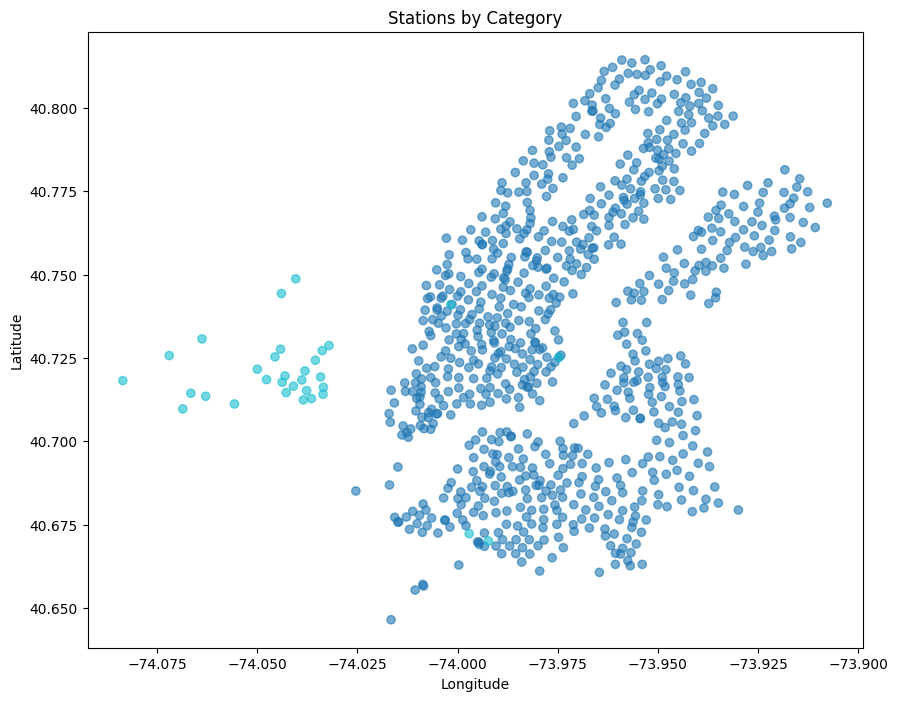

In [40]:
categories = stations['category'].astype('category')
colors = categories.cat.codes  
fig = plt.figure(figsize=(10, 8))
plt.scatter(
    stations['station_longitude'],
    stations['station_latitude'],
    c=colors,
    cmap='tab10',     
    alpha=0.6
)

plt.title('Stations by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


## Clustering

In [41]:
def plot_station_clusters(df):
    n_clusters = len(set(df["station_cluster"]))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, x='station_longitude', y='station_latitude', hue='station_cluster', palette='tab20', ax=ax)
    ax.set_title(f'Station Clusters (n={n_clusters})')

def elbow_method(data, max_k):
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 31), sse, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Sum of squared distances')
    plt.xticks(range(1, 31))
    plt.show()

def silloute_score_plot(data, max_k):
    scores = []
    for k in range(20, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        scores.append(score)
    plt.figure(figsize=(10, 6))
    plt.plot(range(20, max_k + 1), scores, marker='o')
    plt.title('Silhouette Score For Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(20, max_k + 1))
    plt.show()   

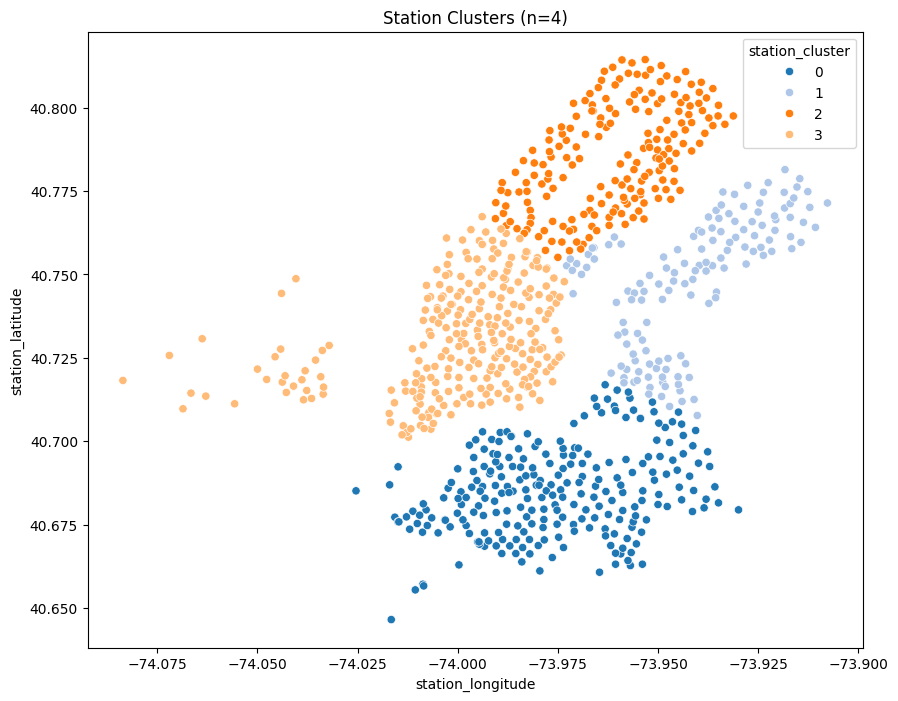

In [42]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_
plot_station_clusters(stations)

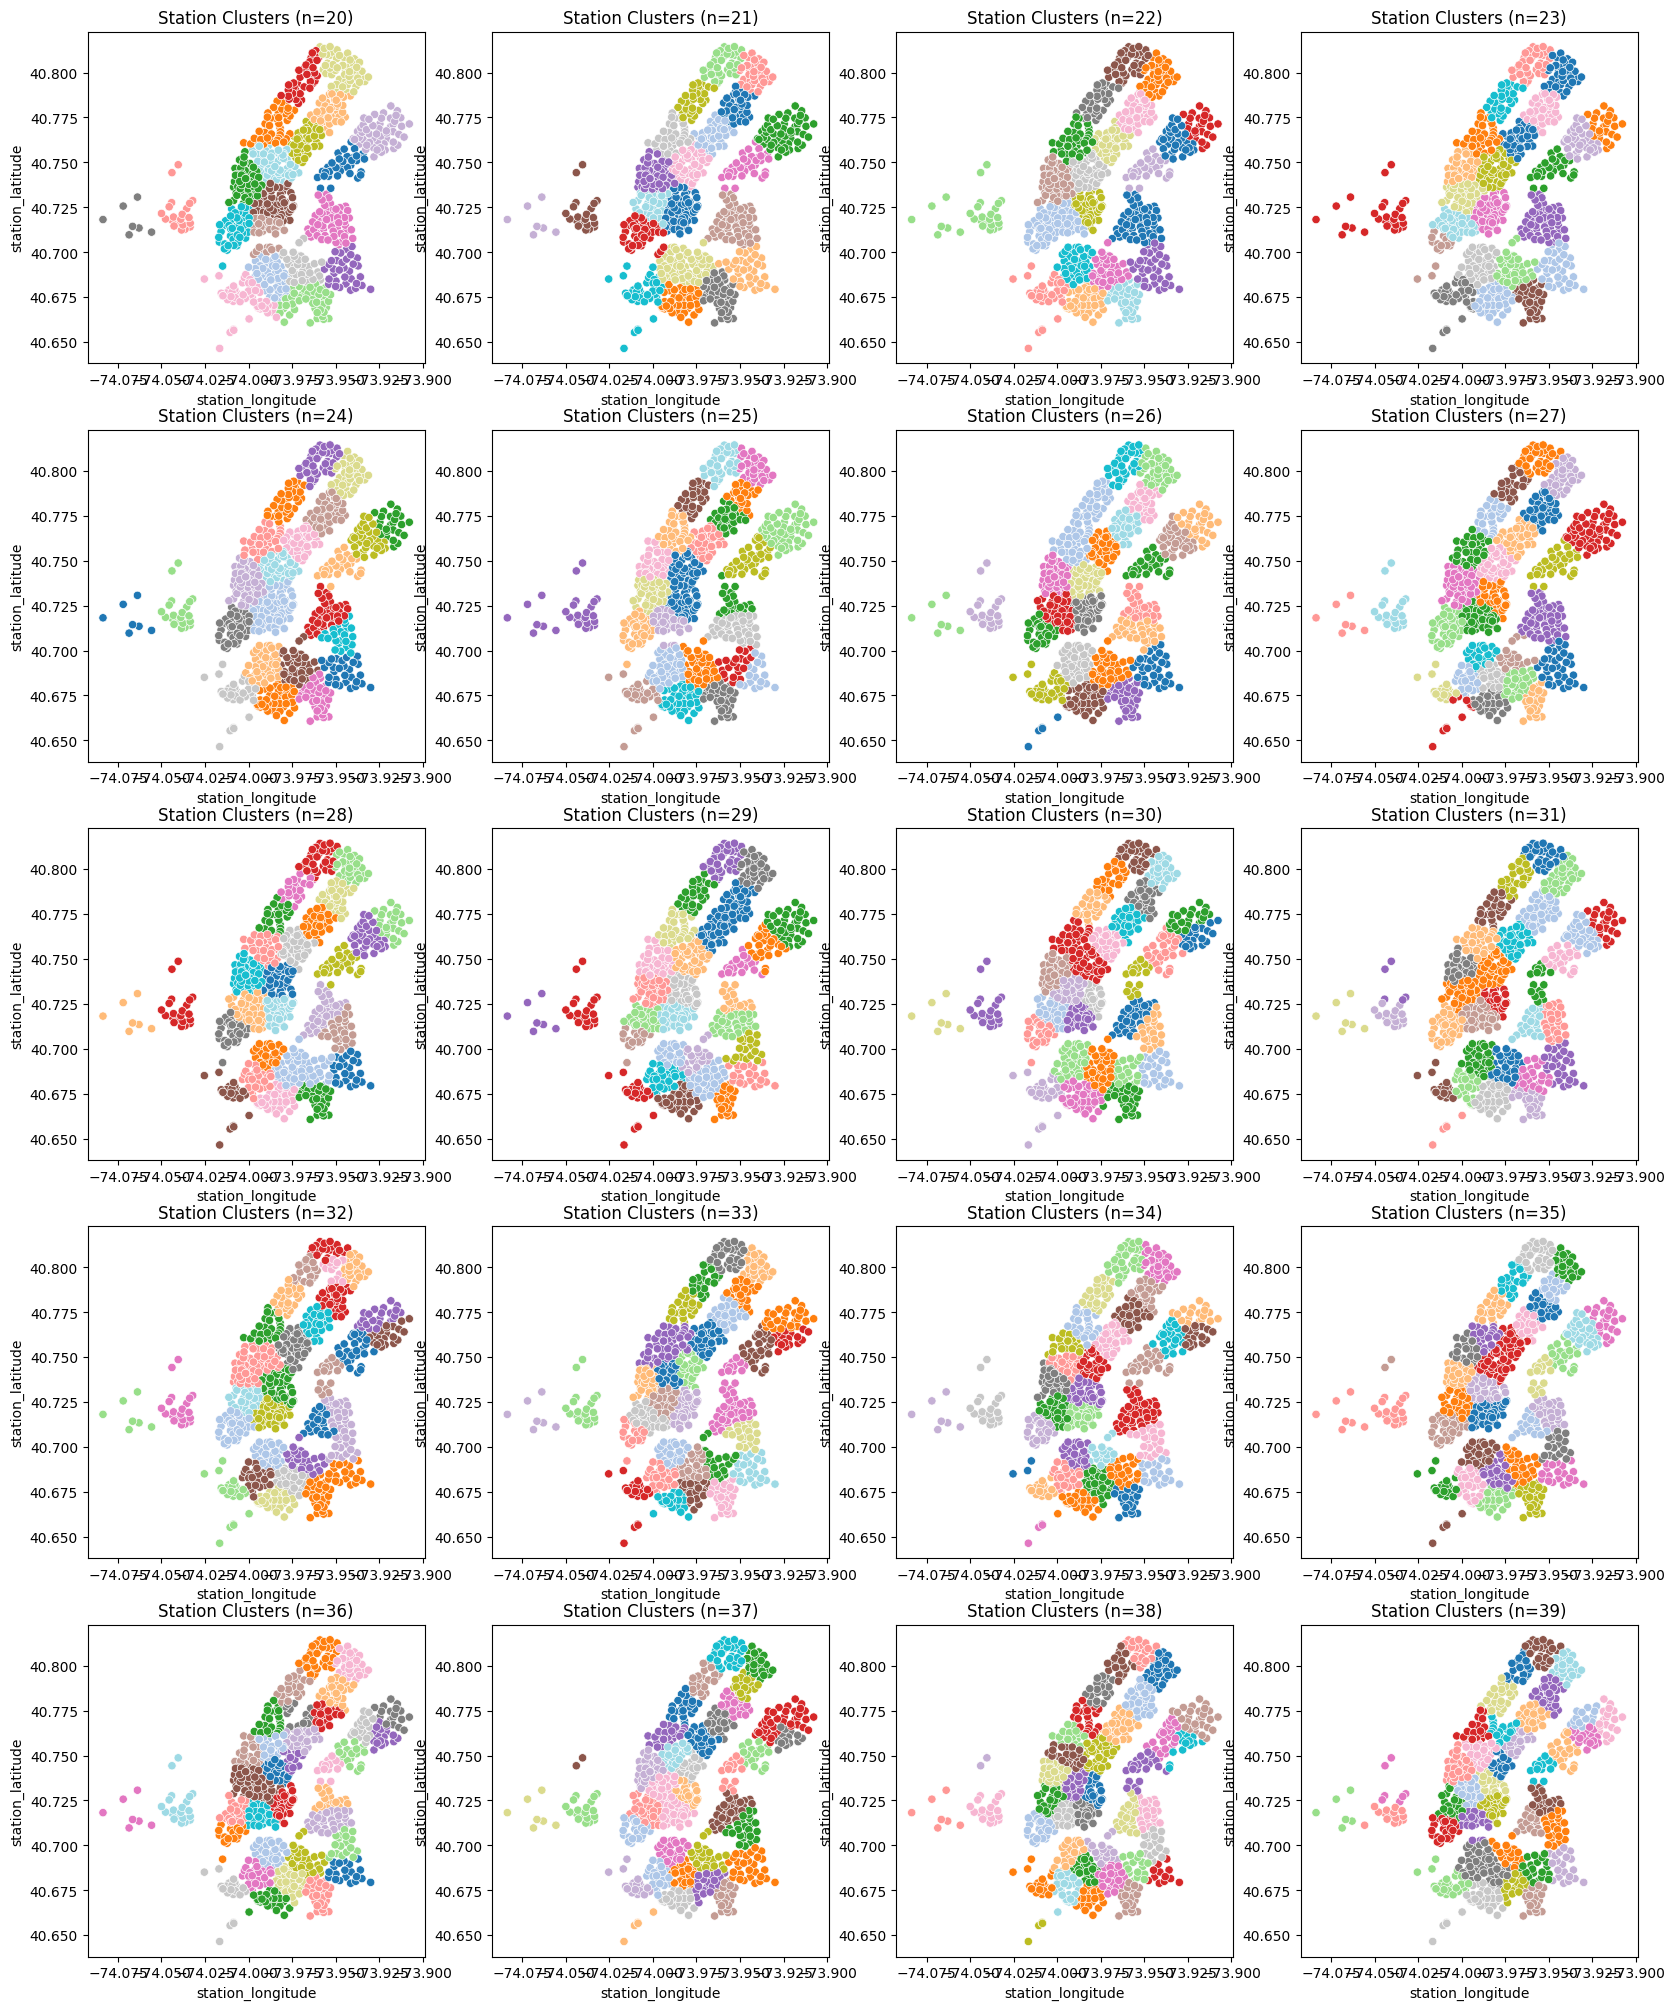

In [43]:
# plot k means for up to 20 clusters
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for n_clusters in range(1, 21):
    kmeans = KMeans(n_clusters=n_clusters+19)
    kmeans.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = kmeans.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend=False, hue='station_cluster', palette='tab20', ax=ax[(n_clusters-1)//4, (n_clusters-1)%4])
    ax[(n_clusters-1)//4, (n_clusters-1)%4].set_title(f'Station Clusters (n={n_clusters+19})')

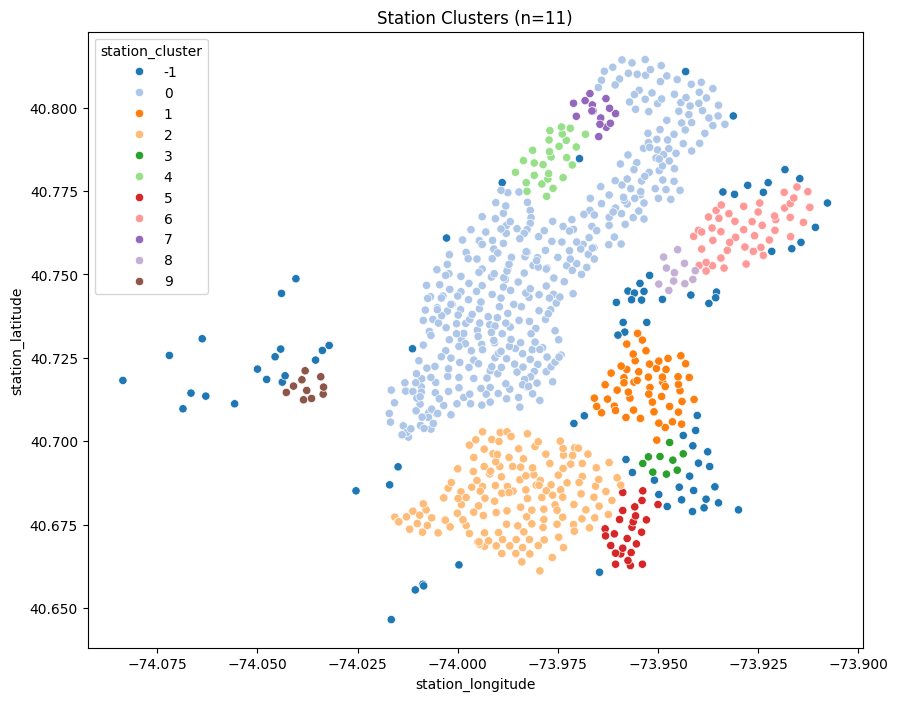

In [44]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.006, min_samples=10)
dbscan.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = dbscan.labels_
plot_station_clusters(stations)

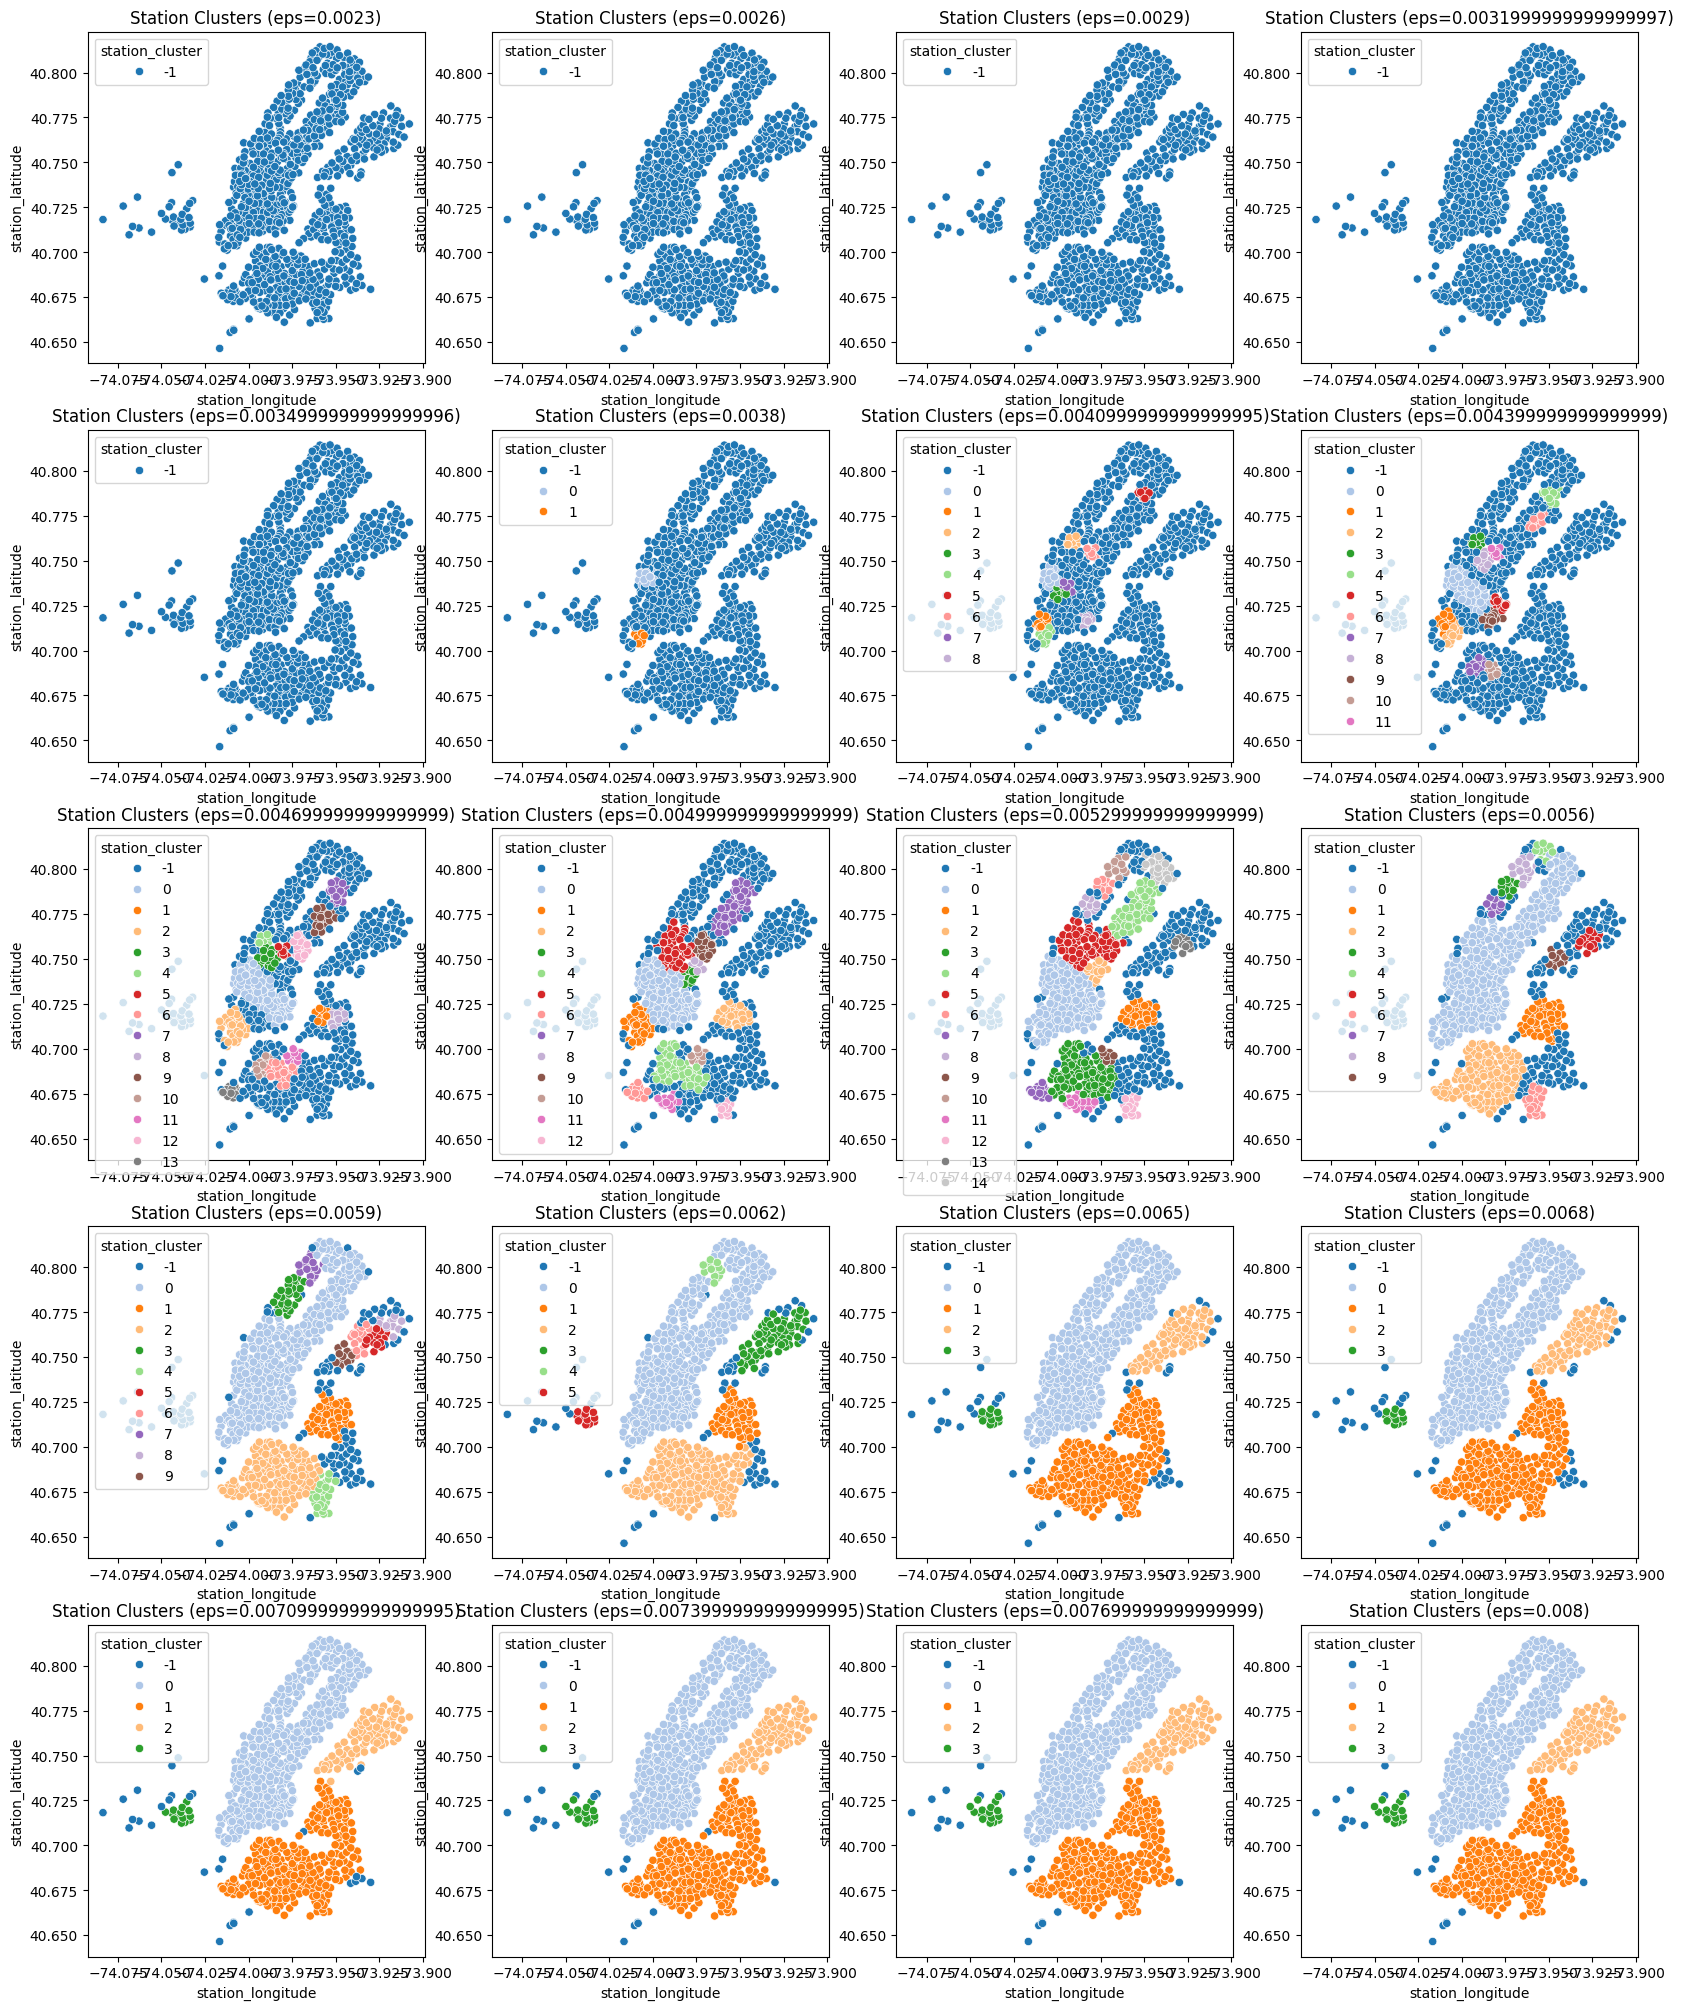

In [45]:
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for i in range(1, 21):
    eps = 0.002+0.0003*i
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = dbscan.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend="full", hue='station_cluster', palette='tab20', ax=ax[(i-1)//4, (i-1)%4])
    ax[(i-1)//4, (i-1)%4].set_title(f'Station Clusters (eps={eps})')

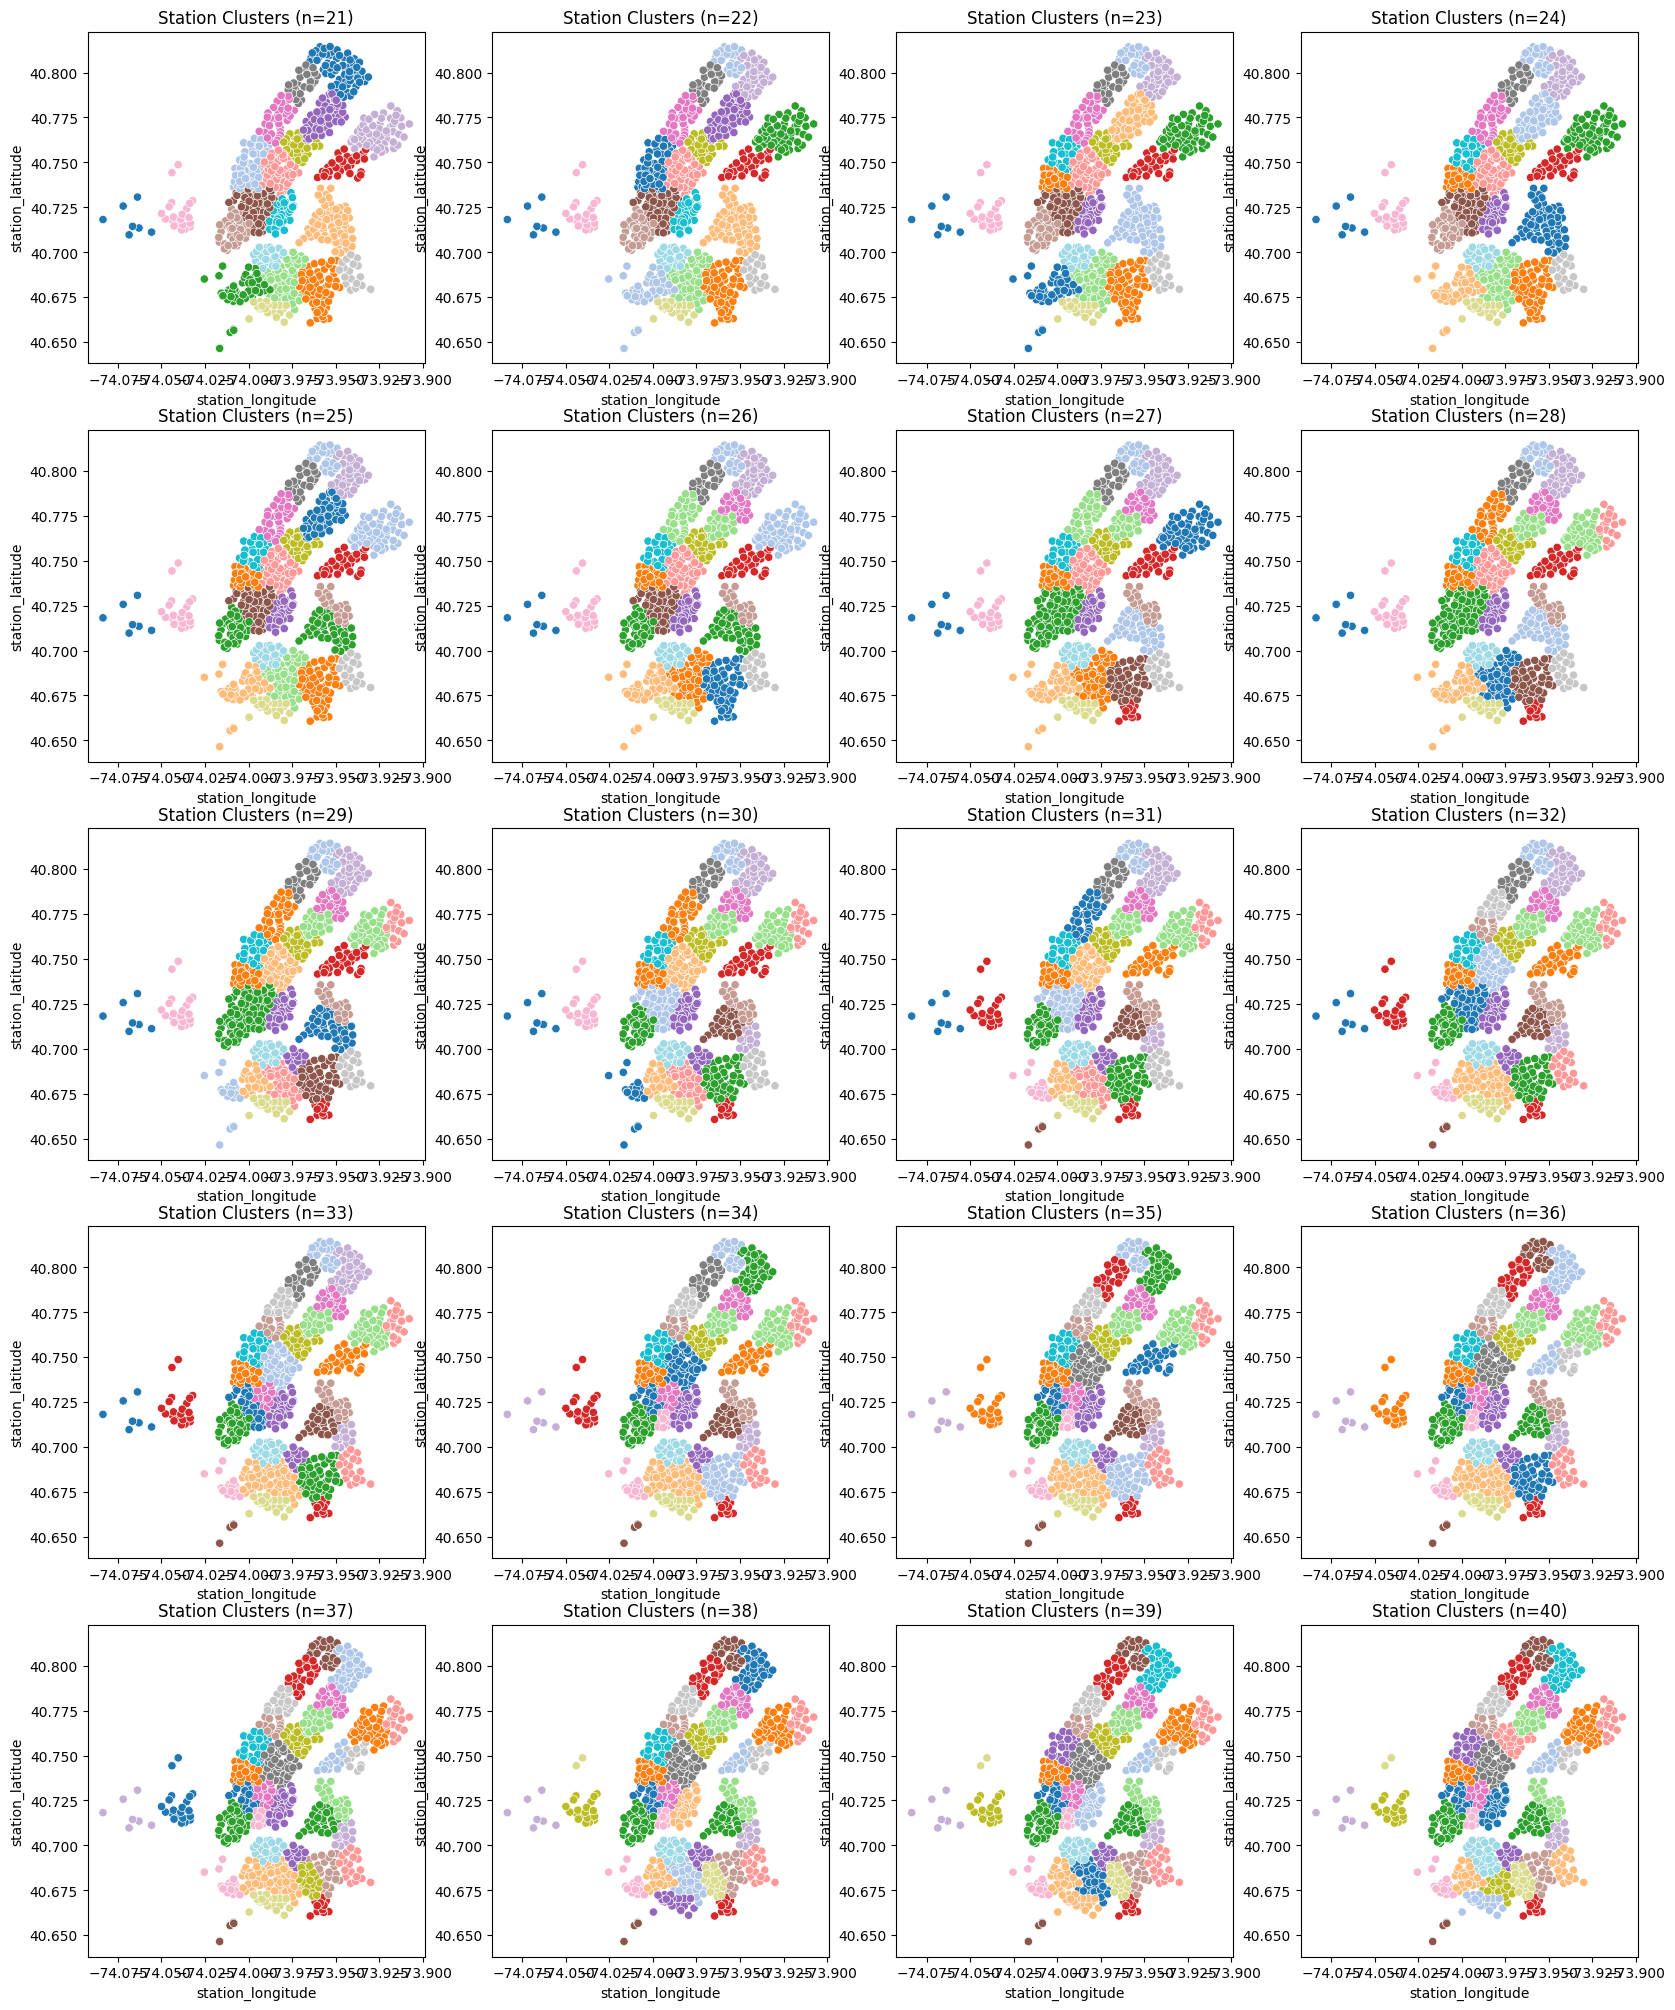

In [46]:
from sklearn.cluster import AgglomerativeClustering

# plot k means for up to 20 clusters
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for n_clusters in range(1, 21):
    agglo = AgglomerativeClustering(n_clusters=n_clusters+20)
    agglo.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = agglo.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend=False, hue='station_cluster', palette='tab20', ax=ax[(n_clusters-1)//4, (n_clusters-1)%4])
    ax[(n_clusters-1)//4, (n_clusters-1)%4].set_title(f'Station Clusters (n={n_clusters+20})')

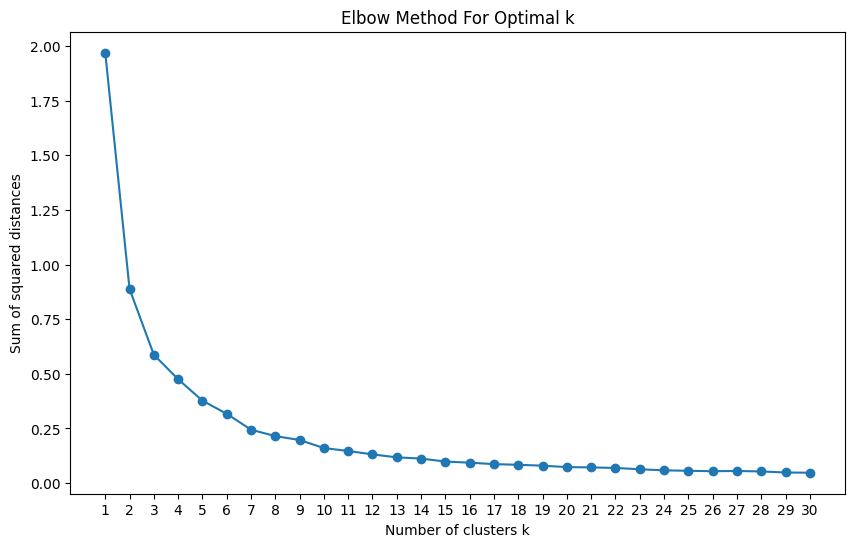

In [47]:
elbow_method(stations[['station_longitude', 'station_latitude']], 30)


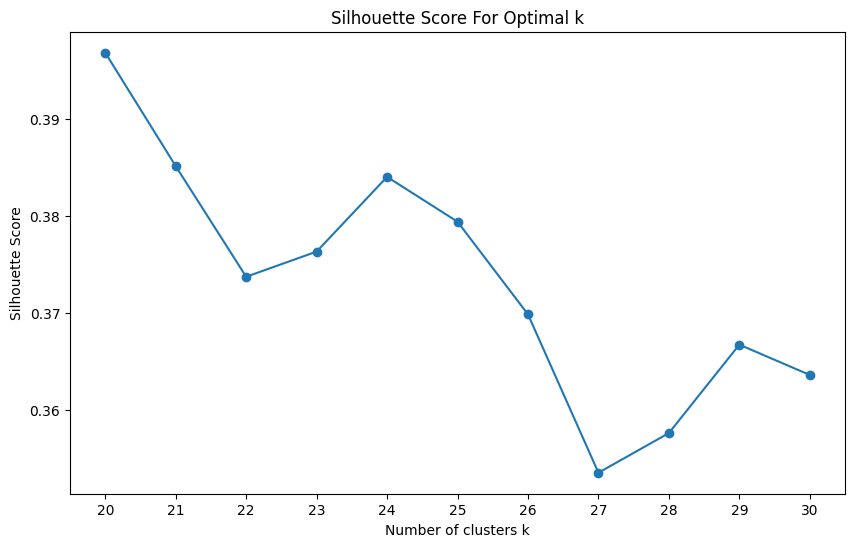

In [48]:
silloute_score_plot(stations[['station_longitude', 'station_latitude']], 30)

In [49]:
kmeans = KMeans(n_clusters=20, random_state=RANDOM_SEED)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_+1

In [50]:
stations.to_csv('../data/processed_stations_2018.csv', index=False)

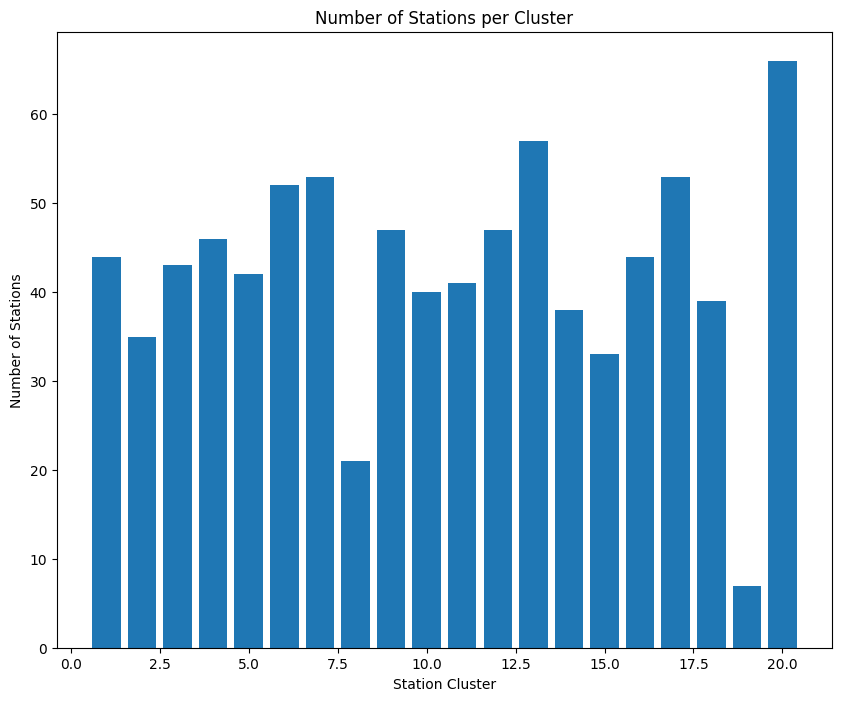

In [51]:
sizes=stations.groupby('station_cluster').size()
fig = plt.figure(figsize=(10, 8))
plt.bar(sizes.index, sizes.values)
plt.xlabel('Station Cluster')
plt.ylabel('Number of Stations')
plt.title('Number of Stations per Cluster')
plt.show()

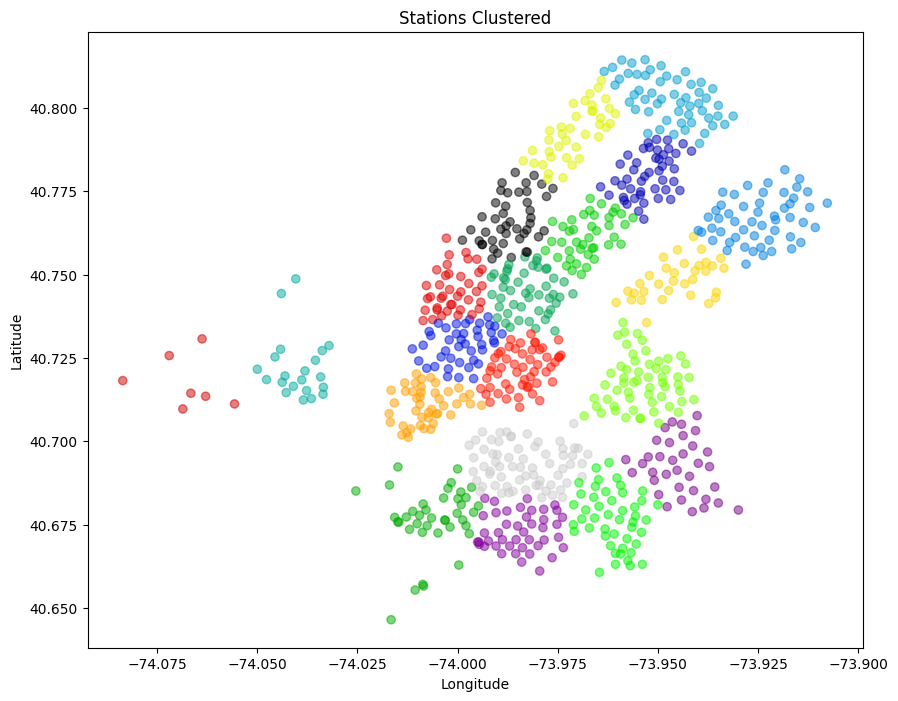

In [56]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(stations['station_longitude'], stations['station_latitude'], c=stations['station_cluster'], cmap='nipy_spectral', alpha=0.5)
plt.title('Stations Clustered')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()